# `pheno_prerank_enrich()` Enrichment: Gene Interaction List with Rank Scores for Phenotypes

### Step 1: Prepare `rank_df`

Begin by preparing a list of gene interactions along with their preranked scores. Store this information in a DataFrame called `rank_df`.

- The **index** of `rank_df` should be the gene interaction symbols. e.g. `Oas1a_Ifit1`
- The **columns** of `rank_df` should correspond to one target phenotype (e.g., GK vs.).

This format allows `pheno_prerank_enrich` to perform enrichment analysis using phenotype-level ranked interaction-level statistics.


In this tutorial, we use gene interaction data from the [GSE13268][GSE13268] dataset, which includes two phenotypes:

- **GK (Goto-Kakizaki):** An inbred rat model commonly used for diabetes research. GK rats exhibit a polygenic form of diabetes, closely mirroring human disease characteristics such as hyperglycemia, impaired glucose tolerance, and insulin resistance. This makes them a valuable model for studying human type 2 diabetes.

- **WKY (Wistar-Kyoto):** A standard inbred laboratory rat strain often used as a control. In this study, WKY rats serve as the reference group for comparison with GK rats, enabling the investigation of insulin resistance and diabetes progression.

For each rat sample, gene–gene interactions and their corresponding entropy-based Critical Transition (CT) scores were precomputed by [NIEE][NIEE]. A differential analysis was then performed between the GK and WKY groups. From this, we identified gene interactions with higher fluctuation in GK rats, ranked by their z-scores from the differential test (`grea/data/GSE13268_GK.csv`).





In [8]:
%load_ext autoreload

import pandas as pd
rank_df = pd.read_csv("grea/data/GSE13268_GK.csv", index_col=0)
rank_df.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,GK vs. WKY
names,
Ifit3_Ifit1,7.116836
Usp18_Ifit1,7.105887
Oas1a_Ifit1,7.105887
Gstm4_Gsta4,7.094938
Gstt1_Gsta4,7.094938


### Step 2: Preparing Gene Set Libraries

There are several ways to prepare gene set libraries for use in GREA:

##### Option 1: Use Built-in Libraries
Simply specify the `libraries` you're interested in as a list. For example:

```python
libraries = ['KEGG_2019_Mouse', 'WikiPathways_2024_Mouse']
```

You can use the `grea.library.list_libraries()` function to view all available pathway libraries included in GREA.

##### Option 2: Load from GMT File
You can load external gene set libraries from `.gmt` files using:

```python
libraries = read_gmt('your_library_file.gmt')
```

##### Option 3: Define a Custom Library
Create your own gene set library using a Python dictionary, where each key is a pathway name and the corresponding value is a list of genes:

```python
libraries = {
    'term1': ['Oas1a', 'Ifit1'],
    'term2': ['Gstm4', 'Oas1a']
}
```

In [2]:
from grea.library import list_libraries

print(list_libraries())

['GeneSigDB', 'Enrichr_Submissions_TF-Gene_Coocurrence', 'SysMyo_Muscle_Gene_Sets', 'WikiPathway_2021_Human', 'HomoloGene', 'WikiPathways_2013', 'PFOCR_Pathways_2023', 'OMIM_Disease', 'Data_Acquisition_Method_Most_Popular_Genes', 'NIBR_Jensen_DISEASES_Curated_2025', 'Cancer_Cell_Line_Encyclopedia', 'WikiPathways_2016', 'WikiPathways_2015', 'RNAseq_Automatic_GEO_Signatures_Human_Up', 'Human_Gene_Atlas', 'KOMP2_Mouse_Phenotypes_2022', 'MoTrPAC_2023', 'Kinase_Perturbations_from_GEO_down', 'Disease_Signatures_from_GEO_down_2014', 'Disease_Perturbations_from_GEO_up', 'Old_CMAP_down', 'MCF7_Perturbations_from_GEO_up', 'NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'PPI_Hub_Proteins', 'Disease_Signatures_from_GEO_up_2014', 'GTEx_Tissue_Expression_Up', 'NIBR_DRUGseq_2025_down', 'L1000_Kinase_and_GPCR_Perturbations_up', 'ARCHS4_Cell-lines', 'VirusMINT', 'KEGG_2019_Human', 'ARCHS4_Tissues', 'MGI_Mammalian_Phenotype_Level_4', 'The_Kinase_Librar

### Step 3: Run Enrichment

To perform enrichment analysis, call the `grea.pheno_prerank_enrich(rank_df, libraries)` function. You can customize the analysis using the following arguments:

- **`prob_method`**: Method for p-value calculation. Currently supports `'perm'` for permutation-based testing.
- **`n_perm`**: Number of permutations to use for estimating the null distribution.
- **`sig_sep`**: The delimiter used to separate gene names in an interaction string (e.g., set `sig_sep='_'` for interactions like `Oas1a_Ifit1`).

The function returns a GREA object containing all enrichment results, including enrichment scores and statistical significance for each library term.


In [9]:
%autoreload

from grea import grea
libraries = ['WikiPathways_2024_Mouse', 'Mouse_Gene_Atlas']
n_perm = 10
prob_method = 'perm'
sig_sep = '_'
obj = grea.pheno_prerank_enrich(rank_df, libraries,n_perm=n_perm, prob_method=prob_method, sig_sep=sig_sep)
obj

---Finished: Load WikiPathways_2024_Mouse with 188 terms.
---WARMING: "Mouse_Gene_Atlas-testis" has 3059 genes, larger than max_size 1000, filter it out.
---Finished: Load Mouse_Gene_Atlas with 95 terms.
Low numer of permutations can lead to inaccurate p-value estimation. Symmetric Gamma distribution enabled to increase accuracy.


### Step 4: Check Enrichment Results

The `GREA` object stores all enrichment results, including enrichment scores and statistical significance for each library term. GREA supports three types of enrichment scores, each reflecting a different scoring strategy:

- `'KS-ES'`: Kolmogorov–Smirnov-based Enrichment Score, capturing the peak deviation between hit and miss distributions.
- `'KS-ESD'`: KS-based enrichment Score Difference, the sum of the maximum positive and negative deviations from the running score.
- `'RC-AUC'`: Area Under the Recovery Curve, summarizing early enrichment of target genes along the ranking.

You can select the appropriate metric depending on your analysis goal or data characteristics.

To retrieve the enrichment results as a long DataFrame, use the `get_enrich_results(metric)` function.


In [10]:
%autoreload

df = obj.get_enrich_results(metric='KS-ES')
df.head()

,Term,Obs,KS-ES,Prob_method,KS-ES_pval,N_lead_sigs,Lead_sigs,KS-ES_fdr,KS-ES_sidak
109,WikiPathways_2024_Mouse|Pentose Phosphate Path...,GK vs. WKY,0.741123,perm,0.01,40,Taldo1_Gpi;Taldo1_Eno1;Tkt_Pdhb;Tkt_Taldo1;Tkt...,0.014588,0.941822
209,Mouse_Gene_Atlas|mammary gland lact,GK vs. WKY,0.676365,perm,0.01,123,Pik3r1_Mtor;Pik3r1_Pdgfrb;Pik3r1_Grap2;Pik3r1_...,0.014588,0.941822
169,WikiPathways_2024_Mouse|Heme Biosynthesis WP18,GK vs. WKY,0.651665,perm,0.01,16,Fech_Abcb10;Alas2_Alad;Fech_Abcb6;Uros_Cpox;Sl...,0.014588,0.941822
183,WikiPathways_2024_Mouse|Methylation WP1247,GK vs. WKY,0.625270,perm,0.01,44,Cyp1a1_Comt;Drd4_Comt;Comt_Aldh3b1;Ugt2b10_Com...,0.014588,0.941822
3,WikiPathways_2024_Mouse|Dysregulated miRNA Tar...,GK vs. WKY,0.619595,perm,0.01,189,Pik3r1_Mtor;Pik3r1_Pdgfrb;Pik3r1_Grap2;Pik3r1_...,0.014588,0.941822


In [11]:
%autoreload

df = obj.get_enrich_results(metric='KS-ESD')
df.head()

,Term,Obs,KS-ESD,Prob_method,KS-ESD_pval,N_lead_sigs,Lead_sigs,KS-ESD_fdr,KS-ESD_sidak
109,WikiPathways_2024_Mouse|Pentose Phosphate Path...,GK vs. WKY,0.731309,perm,0.01,40,Taldo1_Gpi;Taldo1_Eno1;Tkt_Pdhb;Tkt_Taldo1;Tkt...,0.014221,0.941822
209,Mouse_Gene_Atlas|mammary gland lact,GK vs. WKY,0.675842,perm,0.01,123,Pik3r1_Mtor;Pik3r1_Pdgfrb;Pik3r1_Grap2;Pik3r1_...,0.014221,0.941822
169,WikiPathways_2024_Mouse|Heme Biosynthesis WP18,GK vs. WKY,0.640218,perm,0.01,16,Fech_Abcb10;Alas2_Alad;Fech_Abcb6;Uros_Cpox;Sl...,0.014221,0.941822
183,WikiPathways_2024_Mouse|Methylation WP1247,GK vs. WKY,0.620004,perm,0.01,44,Cyp1a1_Comt;Drd4_Comt;Comt_Aldh3b1;Ugt2b10_Com...,0.014221,0.941822
3,WikiPathways_2024_Mouse|Dysregulated miRNA Tar...,GK vs. WKY,0.619071,perm,0.01,189,Pik3r1_Mtor;Pik3r1_Pdgfrb;Pik3r1_Grap2;Pik3r1_...,0.014221,0.941822


In [12]:
%autoreload

df = obj.get_enrich_results(metric='RC-AUC')
df.head()

,Term,Obs,RC-AUC,Prob_method,RC-AUC_pval,RC-AUC_fdr,RC-AUC_sidak
109,WikiPathways_2024_Mouse|Pentose Phosphate Path...,GK vs. WKY,0.914688,perm,0.01,0.026204,0.941822
183,WikiPathways_2024_Mouse|Methylation WP1247,GK vs. WKY,0.875713,perm,0.01,0.026204,0.941822
169,WikiPathways_2024_Mouse|Heme Biosynthesis WP18,GK vs. WKY,0.860808,perm,0.01,0.026204,0.941822
3,WikiPathways_2024_Mouse|Dysregulated miRNA Tar...,GK vs. WKY,0.822837,perm,0.01,0.026204,0.941822
86,WikiPathways_2024_Mouse|Non Homologous End Joi...,GK vs. WKY,0.820583,perm,0.01,0.026204,0.941822


### Step 5: Visualize Enrichment Results

To visualize the enrichment results, use the `pl_running_sum(metric, term, pheno_id)` function by specifying the desired metric, term, and target phenotype.


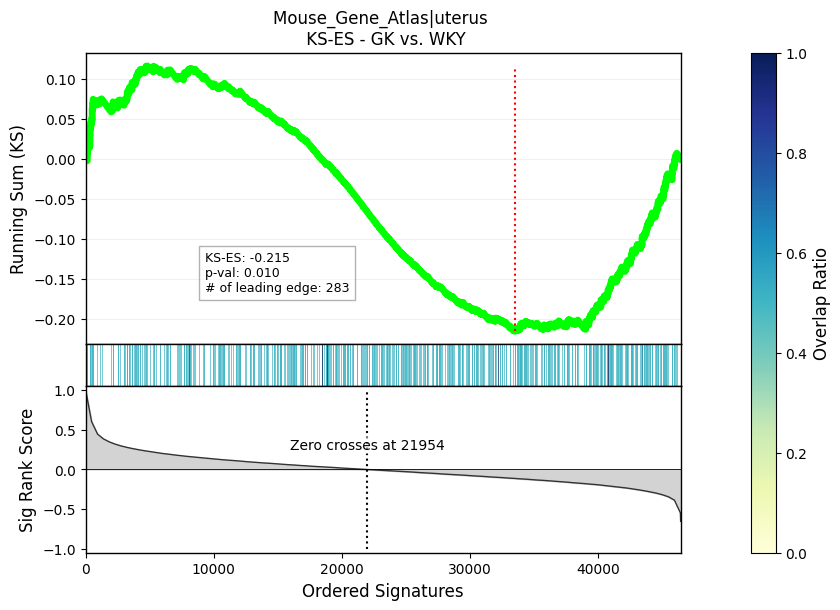

In [17]:
%autoreload
term = 'Mouse_Gene_Atlas|uterus'
pheno_id = 'GK vs. WKY'
fig = obj.pl_running_sum('KS-ES', term, pheno_id)
fig

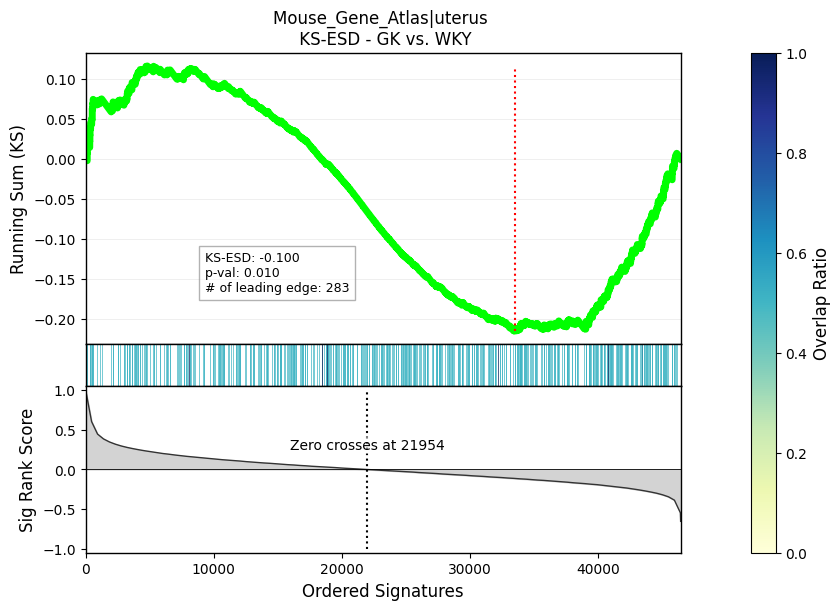

In [18]:
%autoreload
term = 'Mouse_Gene_Atlas|uterus'
pheno_id = 'GK vs. WKY'
fig = obj.pl_running_sum('KS-ESD', term, pheno_id)
fig

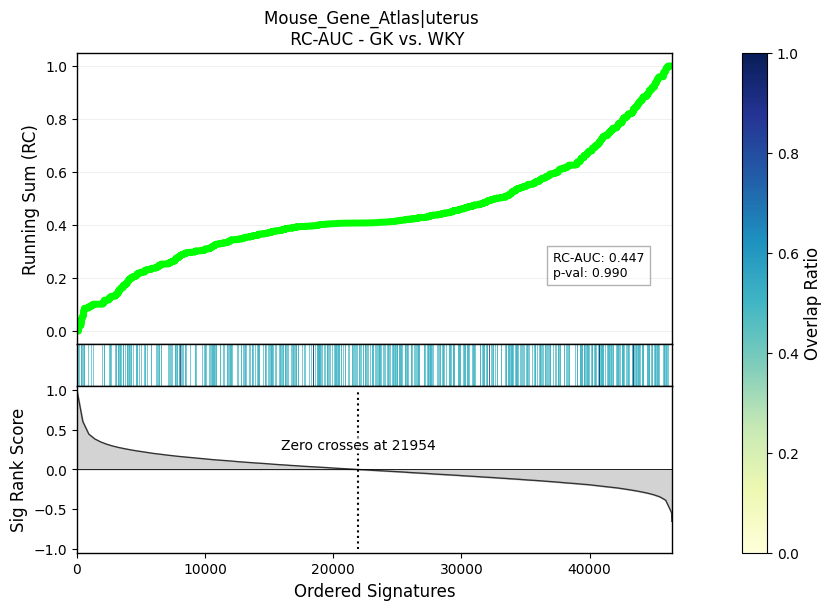

In [19]:
%autoreload
term = 'Mouse_Gene_Atlas|uterus'
pheno_id = 'GK vs. WKY'
fig = obj.pl_running_sum('RC-AUC', term, pheno_id)
fig